In [1]:
from karabo.imaging.imager import Imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation
import matplotlib.pyplot as plt

# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


## Simulation

/home/jennifer/Karabo-Pipeline/karabo/simulation/sky_model.py:809: KaraboWarning: Warning: flux with value <= 0 found, setting those to np.nan to avoid logarithmic errors (only affects the colorbar)
  warn(


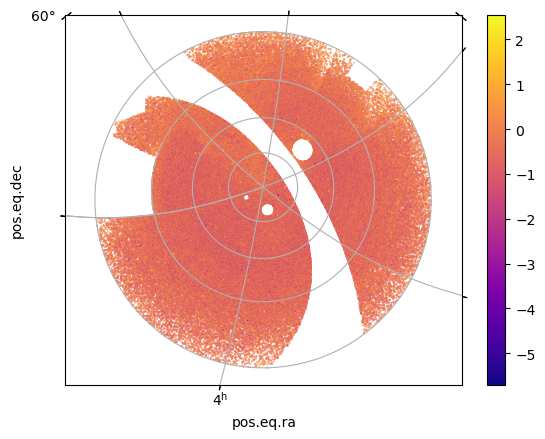

In [2]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky([76])
gleam_sky.explore_sky(phase_center, s=0.1)

Then we filter the sky model based on radius.

In [3]:
sky = gleam_sky.filter_by_radius(0, 0.55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

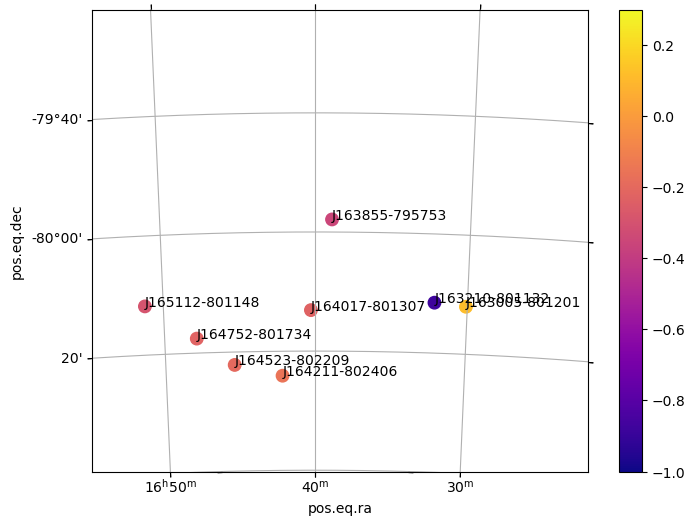

In [4]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246),  # RA-lim
    ylim=(-81, -79),  # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=0.3,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

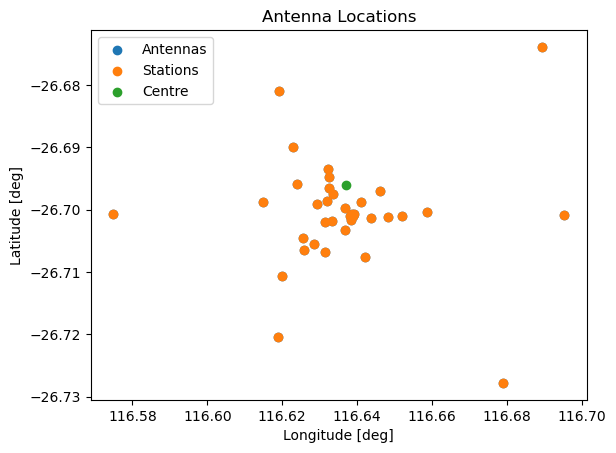

In [5]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [9]:
from karabo.simulation.visibility import Visibility

observation_settings = Observation(
    start_frequency_hz=100e6,
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=64,
    number_of_time_steps=24,
)

# If you want, you can define where karabo should store the visibilities
# If not, karabo will decide where to store it.
vis = Visibility()
vis_path = vis.file.path

print(f"Saving file to {vis_path}")
interferometer_sim = InterferometerSimulation(
    vis_path=vis_path, channel_bandwidth_hz=1e6
)
visibility_askap = interferometer_sim.run_simulation(
    askap_tel,
    sky,
    observation_settings,
)

Saving file to /home/jennifer/Karabo-Pipeline/karabo/examples/karabo_folder/visibility.vis
Parameter 'use_gpus' is None! Using function 'karabo.util.is_cuda_available()' to overwrite parameter 'use_gpu' to True.
Parameter 'use_dask' is None! Using function 'karabo.util.dask.DaskHandler.should_dask_be_used()' to overwrite parameter 'use_dask' to False.
je
W|                                                                   
W|== WARNING: Gaussian ellipse solution failed for 8 sources. These will be simulated as point sources.
W|                                                                   
Saved visibility to /home/jennifer/Karabo-Pipeline/karabo/examples/karabo_folder/visibility.vis


### Dirty Images

We can create dirty images of visibilites and display them as shown below

In [7]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

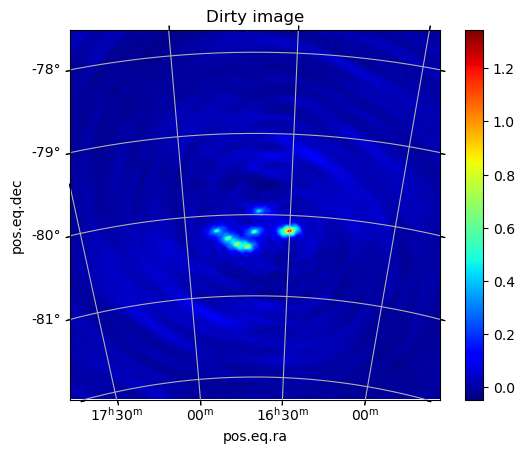

In [8]:
imager_askap = Imager(
    visibility_askap,
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
dirty = imager_askap.get_dirty_image()
dirty.plot(title="Dirty image")

### Source Detection

In [9]:
beam_guess = PyBDSFSourceDetectionResult.guess_beam_parameters(
    imager=imager_askap, method="rascil_1_iter"
)
detection_result_dirty = PyBDSFSourceDetectionResult.detect_sources_in_image(
    image=dirty, beam=beam_guess
)

--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/dirty'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 64
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (8.44041e-02, 5.07806e-02, 103.7) degrees
--> Channels averaged with uniform weights
--> Source extraction will be done on averaged ("ch0") image
Frequency of averaged image ............. : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 60.572 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (1315, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.02e-02 Jy/beam
Value of background mean ................ : 0.00292 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping

Fitting islands with Gaussians .......... : [|] 0/4/Fitting islands with Gaussians .......... : [/] 1/4-Fitting islands with Gaussians .......... : [-] 2/4\Fitting islands with Gaussians .......... : [\] 3/4Fitting islands with Gaussians .......... : [] 4/4[-3GFitting islands with Gaussians .......... : [] 4/4[-3G

Total number of Gaussians fit to image .. : 20
Total flux density in model ............. : 19.945 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 6
    Island #0 (x=753, y=472): fit with 1 Gaussian with flag = 320
    Island #3 (x=1368, y=1335): fit with 2 Gaussians with flags = 320, 270
Please check these islands. If they are valid islands and
should be fit, try adjusting the flagging options (use
show_fit with "ch0_flagged=True" to see the flagged Gaussians
and "help 'flagging_opts'" to see the meaning of the flags)
or enabling the wavelet module (with "atrous_do=True").
To include empty islands in output source catalogs, set
incl_empty=True in the write_catalog task.


--> Wrote ASCII file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/sources'
--> Wrote file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/result'


In [10]:
ground_truth, sky_idxs = Imager.project_sky_to_image(
    sky=sky,
    phase_center=phase_center,
    imaging_cellsize=imaging_cellsize,
    imaging_npixel=imaging_npixel,
    filter_outlier=True,
    invert_ra=True,
)

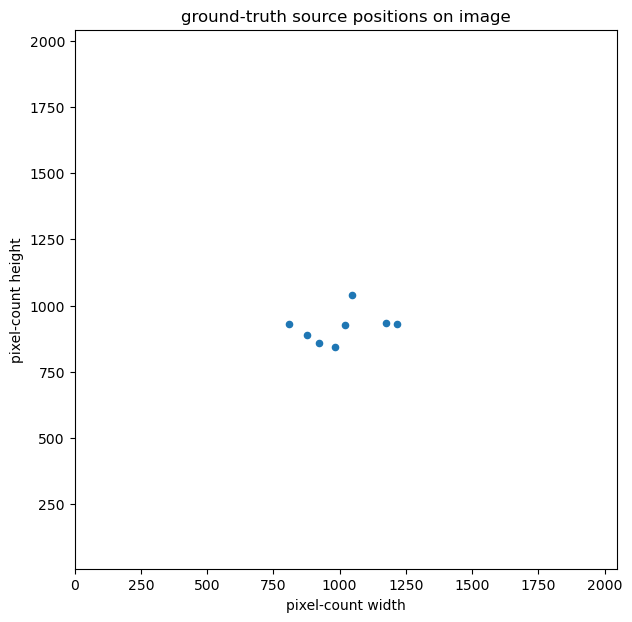

In [11]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()

In [12]:
assignments_dirty = (
    SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
        ground_truth=ground_truth.T,
        detected=detection_result_dirty.get_pixel_position_of_sources(),
        max_dist=10,
        top_k=3,
    )
)
assignments_dirty

array([[-1.        ,  0.        ,         inf],
       [-1.        , 17.        ,         inf],
       [-1.        , 16.        ,         inf],
       [-1.        , 15.        ,         inf],
       [-1.        , 14.        ,         inf],
       [-1.        , 13.        ,         inf],
       [-1.        , 12.        ,         inf],
       [-1.        , 11.        ,         inf],
       [-1.        , 19.        ,         inf],
       [-1.        , 10.        ,         inf],
       [-1.        ,  4.        ,         inf],
       [-1.        ,  2.        ,         inf],
       [-1.        ,  1.        ,         inf],
       [ 0.        ,  5.        ,  1.61636562],
       [ 1.        ,  7.        ,  0.61076346],
       [ 2.        ,  6.        ,  0.10093501],
       [ 3.        ,  3.        ,  0.91808377],
       [ 4.        ,  8.        ,  0.83238085],
       [ 5.        , -1.        ,         inf],
       [ 6.        ,  9.        ,  0.61786934],
       [ 7.        , 18.        ,  0.662

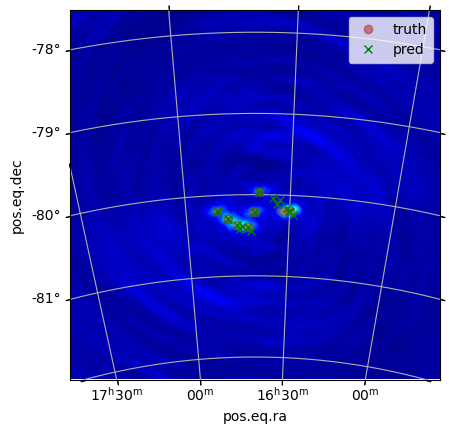

In [13]:
sde_dirty = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_dirty,
    sky_idxs=sky_idxs,
    source_detection=detection_result_dirty,
)
sde_dirty.plot()

### Imaging
Of course, we can also do source detection on cleaned (clean algorithmus by rascil) images.

In [14]:
imager_askap.ingest_chan_per_vis = 1
imager_askap.ingest_vis_nchan = 16

# Try differnet algorithm
# More sources
deconvolved, restored, residual = imager_askap.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm="mmclean",
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=0.3,
    clean_threshold=0.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output="integrated",
)

## Analysis via Source Detection

Source Detection on restored image.

In [15]:
detection_result = PyBDSFSourceDetectionResult.detect_sources_in_image(restored)

--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/restored'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (8.44041e-02, 5.07806e-02, -76.3) degrees
Frequency of image ...................... : 100.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 22.493 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (1361, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 7.96e-03 Jy/beam
Value of background mean ................ : 0.00136 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 327
Number of islands found .......

Fitting islands with Gaussians .......... : [|] 0/6/Fitting islands with Gaussians .......... : [/] 1/6-Fitting islands with Gaussians .......... : [-] 2/6\Fitting islands with Gaussians .......... : [\] 3/6|Fitting islands with Gaussians .......... : [|] 4/6/Fitting islands with Gaussians .......... : [/] 5/6Fitting islands with Gaussians .......... : [] 6/6[-3GFitting islands with Gaussians .......... : [] 6/6[-3G

Total number of Gaussians fit to image .. : 29
Total flux density in model ............. : 9.343 Jy


--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 4
    Island #0 (x=713, y=482): fit with 1 Gaussian with flag = 320
    Island #2 (x=899, y=981): fit with 1 Gaussian with flag = 256
    Island #5 (x=1365, y=1333): fit with 3 Gaussians with flags = 368, 260, 268
Please check these islands. If they are valid islands and
should be fit, try adjusting the flagging options (use
show_fit with "ch0_flagged=True" to see the flagged Gaussians
and "help 'flagging_opts'" to see the meaning of the flags)
or enabling the wavelet module (with "atrous_do=True").
To include empty islands in output source catalogs, set
incl_empty=True in the write_catalog task.


--> Wrote ASCII file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/sources'
--> Wrote file '/home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/result'


## Evaluation

In [43]:
assignments_restored = (
    SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(
        ground_truth=ground_truth.T,
        detected=detection_result.get_pixel_position_of_sources(),
        max_dist=5,
        top_k=10,
    )
)
assignments_restored

array([[-1.        ,  0.        ,         inf],
       [-1.        , 27.        ,         inf],
       [-1.        , 25.        ,         inf],
       [-1.        , 24.        ,         inf],
       [-1.        , 23.        ,         inf],
       [-1.        , 22.        ,         inf],
       [-1.        , 21.        ,         inf],
       [-1.        , 19.        ,         inf],
       [-1.        , 18.        ,         inf],
       [-1.        , 17.        ,         inf],
       [-1.        , 16.        ,         inf],
       [-1.        , 15.        ,         inf],
       [-1.        , 28.        ,         inf],
       [-1.        , 14.        ,         inf],
       [-1.        , 12.        ,         inf],
       [-1.        , 10.        ,         inf],
       [-1.        ,  8.        ,         inf],
       [-1.        ,  7.        ,         inf],
       [-1.        ,  6.        ,         inf],
       [-1.        ,  4.        ,         inf],
       [-1.        ,  3.        ,       

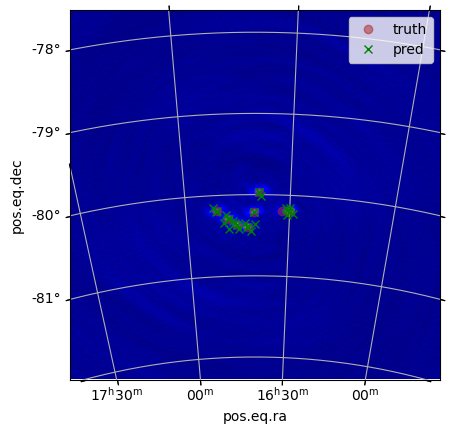

In [44]:
# Create mapping plots
sde_restored = SourceDetectionEvaluation(
    sky=sky,
    ground_truth=ground_truth,
    assignments=assignments_restored,
    sky_idxs=sky_idxs,
    source_detection=detection_result,
)
sde_restored.plot()

In [18]:
# Confusion Matrix
sde_restored.get_confusion_matrix()

array([[ 0., 22.],
       [ 1.,  7.]])

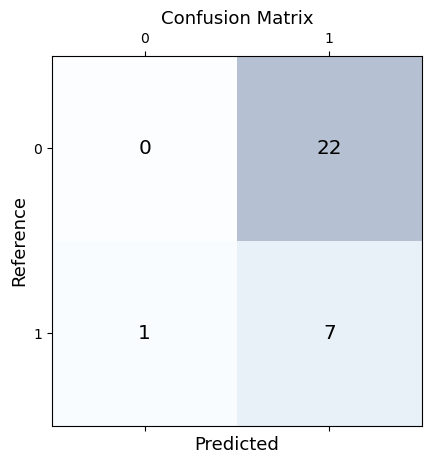

In [19]:
sde_restored.plot_confusion_matrix()

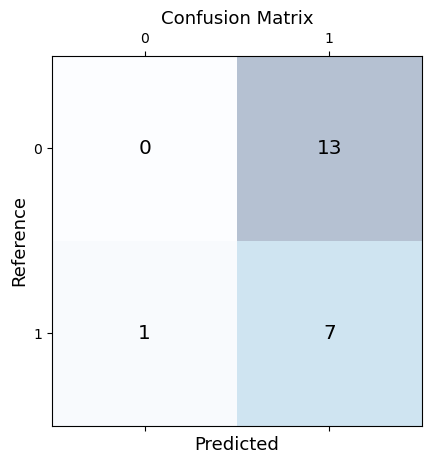

In [20]:
sde_dirty.plot_confusion_matrix()

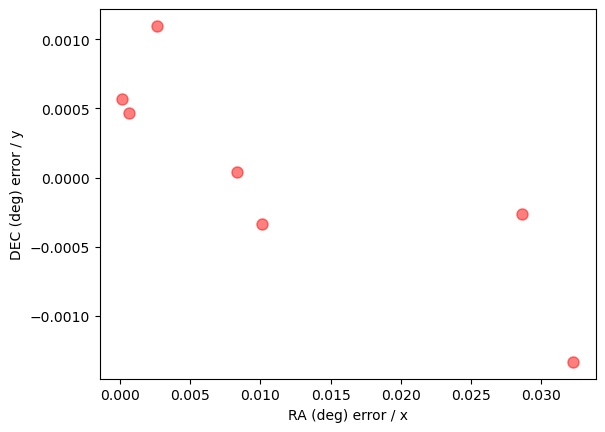

In [21]:
# Plot error ra and dec
sde_restored.plot_error_ra_dec()

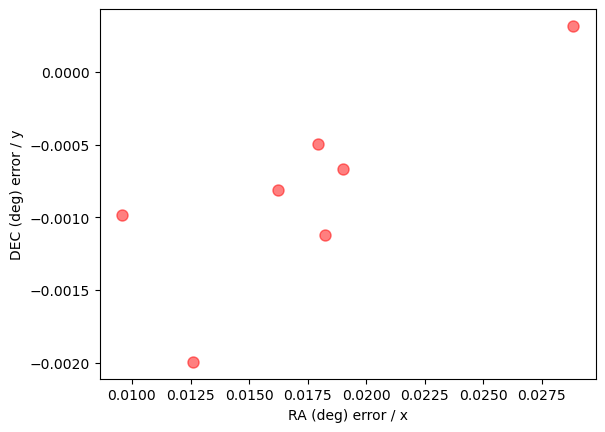

In [22]:
# Plot error ra and dec
sde_dirty.plot_error_ra_dec()

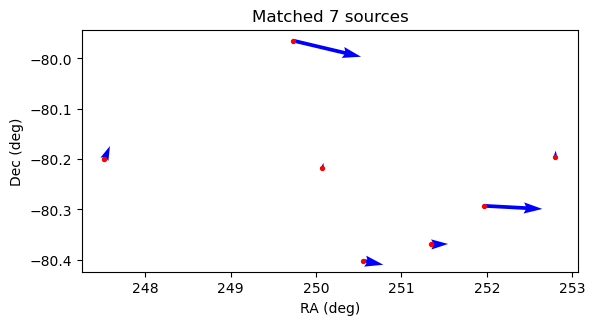

In [23]:
# Plot error flux
sde_restored.plot_quiver_positions()

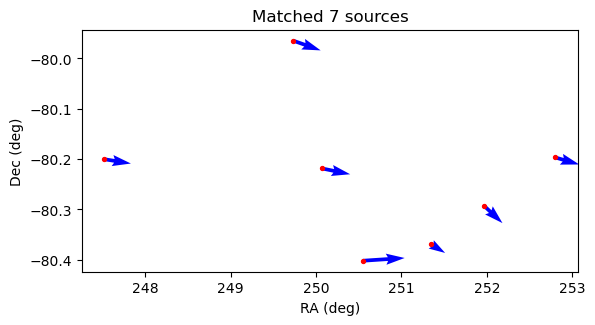

In [24]:
# Plot error flux
sde_dirty.plot_quiver_positions()

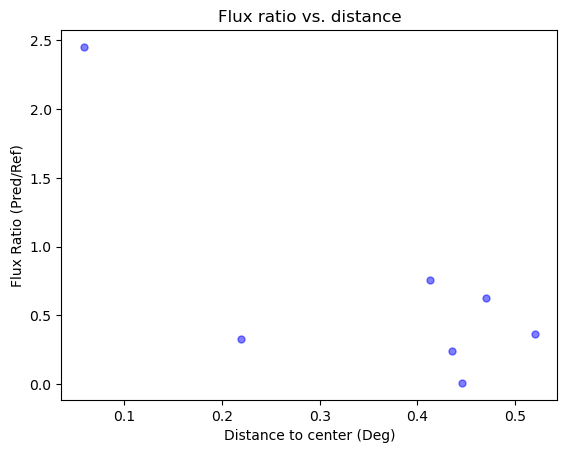

In [25]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_distance()

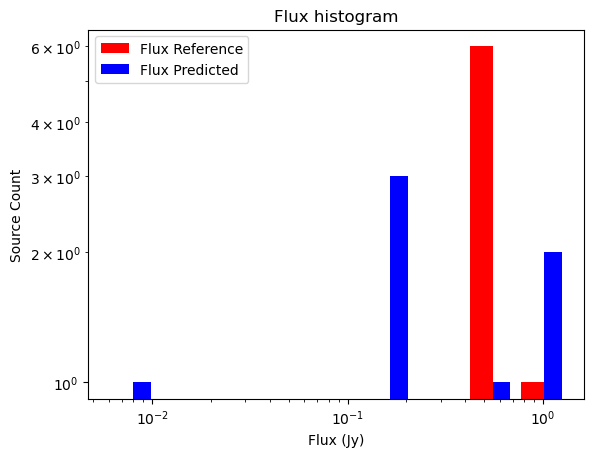

In [26]:
# Plot error ra and dec
sde_restored.plot_flux_histogram()

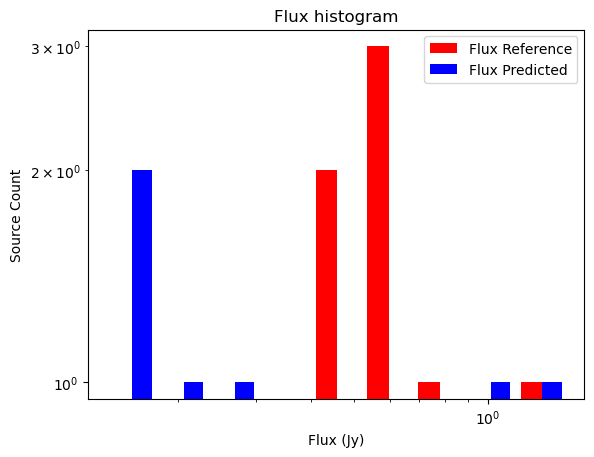

In [27]:
# Plot error ra and dec
sde_dirty.plot_flux_histogram()

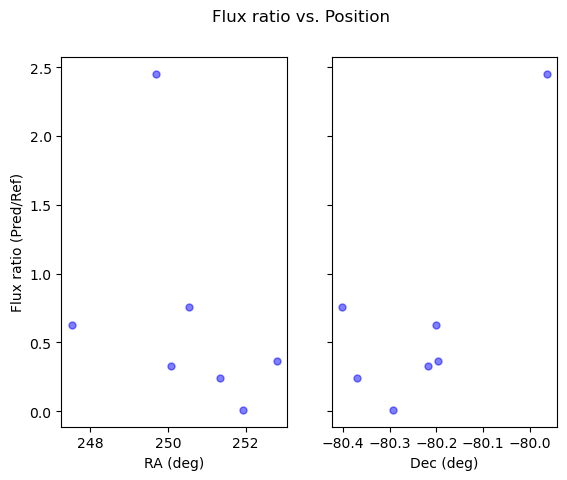

In [28]:
# Plot error ra and dec
sde_restored.plot_flux_ratio_to_ra_dec()

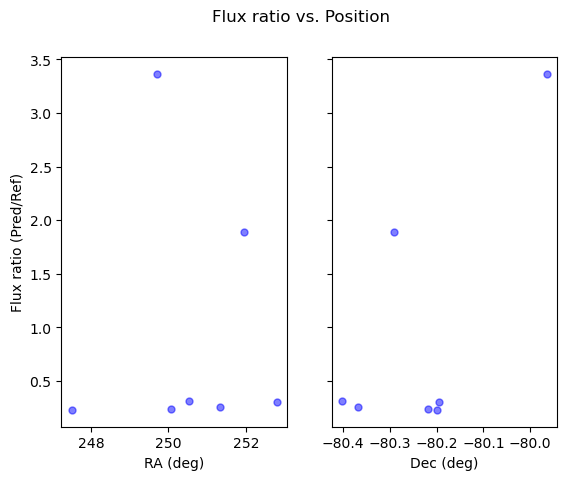

In [29]:
# Plot error ra and dec
sde_dirty.plot_flux_ratio_to_ra_dec()

In [30]:
from karabo.util.file_handler import FileHandler

# Clean up directories which you didn't explicitly define, if you like
FileHandler.clean_up_fh_root()